In [1]:
# !pip list

In [2]:
import tensorflow as tf
import  warnings
warnings.filterwarnings('ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
import pandas as pd
import numpy as np

In [5]:
balanced_df = pd.read_csv('datasets/HateSpeechDatasetBalanced.csv')
normal_df = pd.read_csv('datasets/HateSpeechDataset.csv')

In [6]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [7]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440906 entries, 0 to 440905
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Content      440906 non-null  object
 1   Label        440906 non-null  object
 2   Content_int  440906 non-null  object
dtypes: object(3)
memory usage: 10.1+ MB


In [8]:
balanced_df[balanced_df['Label'] == 0]

,Content,Label
523,simply copy and paste the following text into ...,0
524,in order to help increase the booklets downloa...,0
525,as of the booklet had been downloaded over tim...,0
527,click on the download my bad green banner link,0
528,booklet updated on,0
...,...,...
440894,crash another movie from left field i have to ...,0
440895,i why do not you debate first before starting ...,0
440896,removal of i reverted the removal of the above...,0
440897,i have unblocked you eddie as i discussed on u...,0


In [9]:
balanced_df[balanced_df['Label'] == 1]

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
...,...,...
726114,i mute this telecasting and played kanye west ...,1
726115,but hell yeah he s not a bachelor but looooooo...,1
726116,great video musician but s not my musician lol...,1
726117,not great pop video yeah he s not a pedophile ...,1


In [10]:
len(balanced_df[balanced_df['Label'] == 1]) - len(balanced_df[balanced_df['Label'] == 0])

2931

In [11]:
balanced_df['Label'].value_counts()

Label
1    364525
0    361594
Name: count, dtype: int64

In [12]:
X = balanced_df['Content'].head(50000)
y= balanced_df['Label'].head(50000)

In [13]:
X

0        denial of normal the con be asked to comment o...
1        just by being able to tweet this insufferable ...
2        that is retarded you too cute to be single tha...
3        thought of a real badass mongol style declarat...
4                                      afro american basho
                               ...                        
49995    next time i see an arab i will punch him in th...
49996                       unis should burn to the ground
49997    synagogues should burn to the ground with all ...
49998                trrassssshhh lesssssssbiiiiiiiiiannnn
49999    trrassssshhh uncleanliness i will write it thi...
Name: Content, Length: 50000, dtype: object

In [14]:
y

0        1
1        1
2        1
3        1
4        1
        ..
49995    1
49996    0
49997    1
49998    1
49999    0
Name: Label, Length: 50000, dtype: int64

In [15]:
from keras.utils import to_categorical
y = np.array(y)
y_enc = to_categorical(y, num_classes=len(balanced_df['Label'].value_counts()))

In [16]:
y_enc

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [17]:
y_enc.shape

(50000, 2)

In [18]:
MAX_FEATURES = 200000

In [19]:
from tensorflow.keras.layers import TextVectorization

In [20]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [21]:
vectorizer.adapt(X.values)
print(X.values)

2024-01-13 07:09:02.285096: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


['denial of normal the con be asked to comment on tragedies an emotional retard'
 'just by being able to tweet this insufferable bullshit proves trump a nazi you vagina'
 'that is retarded you too cute to be single that is life' ...
 'synagogues should burn to the ground with all them yids inside'
 'trrassssshhh lesssssssbiiiiiiiiiannnn'
 'trrassssshhh uncleanliness i will write it this where are you to see if my teenage son finally gets it']


In [22]:
vectorized_text = vectorizer(X.values)

In [23]:
print(vectorized_text)

tf.Tensor(
[[ 1018     9   630 ...     0     0     0]
 [   30    70    97 ...     0     0     0]
 [   11     6   163 ...     0     0     0]
 ...
 [ 7973    61  1151 ...     0     0     0]
 [ 4277 23234     0 ...     0     0     0]
 [ 4277 10526     5 ...     0     0     0]], shape=(50000, 1800), dtype=int64)


In [24]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y_enc))
dataset = dataset.cache()
dataset = dataset.shuffle(25000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [26]:
len(train)

1094

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, BatchNormalization

In [28]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

2024-01-13 07:09:03.313016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-13 07:09:03.313747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-13 07:09:03.314165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                          

In [31]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


2024-01-13 07:09:03.580235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [50000,1800]
	 [[{{node Placeholder/_0}}]]
2024-01-13 07:09:03.580409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,2]
	 [[{{node Placeholder/_1}}]]
2024-01-13 07:09:03.710294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

1094/1094 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7310

2024-01-13 07:17:54.817957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [50000,1800]
	 [[{{node Placeholder/_0}}]]
2024-01-13 07:17:54.818161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000,2]
	 [[{{node Placeholder/_1}}]]
2024-01-13 07:17:54.952976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

1094/1094 [==============================] - 548s 500ms/step - loss: 0.5487 - accuracy: 0.7310 - val_loss: 0.5118 - val_accuracy: 0.7788
Epoch 2/10
1094/1094 [==============================] - 1276s 1s/step - loss: 0.4517 - accuracy: 0.7876 - val_loss: 0.4262 - val_accuracy: 0.8000
Epoch 3/10
1094/1094 [==============================] - 1790s 2s/step - loss: 0.3932 - accuracy: 0.8193 - val_loss: 0.3906 - val_accuracy: 0.8216
Epoch 4/10
1094/1094 [==============================] - 920s 841ms/step - loss: 0.3528 - accuracy: 0.8405 - val_loss: 0.3482 - val_accuracy: 0.8500
Epoch 5/10
1094/1094 [==============================] - 522s 477ms/step - loss: 0.3137 - accuracy: 0.8601 - val_loss: 0.3129 - val_accuracy: 0.8651
Epoch 6/10
1094/1094 [==============================] - 519s 474ms/step - loss: 0.2810 - accuracy: 0.8780 - val_loss: 0.2775 - val_accuracy: 0.8851
Epoch 7/10
1094/1094 [==============================] - 589s 538ms/step - loss: 0.2497 - accuracy: 0.8922 - val_loss: 0.2492 - 

In [32]:
model.save('hate_speach_model.h5')

<Figure size 800x500 with 0 Axes>

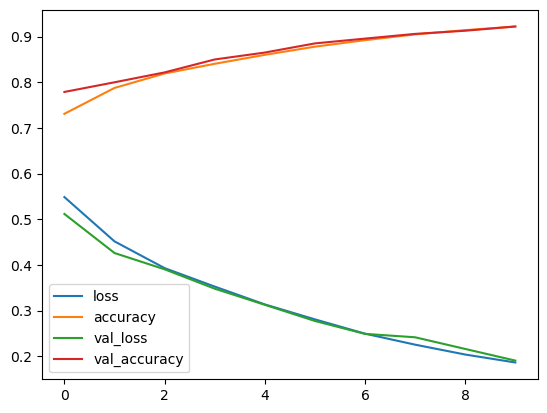

In [33]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 5))
pd.DataFrame(hist.history).plot()
plt.show()

In [72]:
for batch in test.as_numpy_iterator():
    xtrue, ytrue = batch
    yhat = model.predict(xtrue)
    for i,j in zip(yhat ,ytrue):
        print(np.argmax(i), np.argmax(j))

1/1 [==============================] - 0s 83ms/step
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 1
0 0
1 1
0 0
0 0
1 1
0 0
0 1
0 0
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1/1 [==============================] - 0s 63ms/step
0 0
1 1
0 1
0 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
1 1
1 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 1
0 0
0 0
0 0
0 1
1/1 [==============================] - 0s 75ms/step
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 1
0 0
0 0
1 1
0 0
1 1
1 0
0 0
1 0
0 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
0 0
1 0
0 0
0 0
1/1 [==============================] - 0s 61ms/step
0 0
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 0
0 0
1 1
0 0
1 1
1 1
0 1
1/1 [==============================] - 0s 61ms/step
0 0
1 1
0 0
1 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 1
1 1
0 1
0 0
0 0
0 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
0 1
1 1
0 0
0 0
0 0
1/1 [==============================] - 0s 64ms/step
1 1
1 1
1 1
0 0
1 1
1 0
0 0
0 0
1 1
0 0
0 0
1 1


In [82]:
len(test)

156

In [83]:
len(yhat)

32

In [84]:
xtrue.shape

(32, 1800)

In [85]:
ytrue.shape

(32, 2)

In [86]:
ytrue

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [87]:
yhat

array([[6.63326204e-01, 2.99964875e-01],
       [9.98077333e-01, 1.06104642e-01],
       [7.05490708e-01, 2.44800165e-01],
       [6.51670806e-03, 6.62593842e-01],
       [1.75632611e-02, 6.75957680e-01],
       [9.60848212e-01, 9.05515254e-02],
       [7.71944463e-01, 1.04083233e-01],
       [9.26968157e-01, 9.37528461e-02],
       [9.47784364e-01, 9.28185061e-02],
       [6.70296177e-02, 6.92021966e-01],
       [1.64013381e-05, 2.59472877e-01],
       [7.31668591e-01, 1.36742279e-01],
       [9.99273777e-01, 8.81131664e-02],
       [7.70460069e-01, 1.15368798e-01],
       [7.60451913e-01, 1.11963853e-01],
       [8.40781331e-01, 1.02960594e-01],
       [6.84137642e-01, 2.73144603e-01],
       [9.94292438e-01, 1.23084709e-01],
       [9.78579223e-01, 9.69814509e-02],
       [6.53857052e-01, 3.17181289e-01],
       [4.93123880e-05, 2.92712718e-01],
       [7.74282753e-01, 1.09874204e-01],
       [6.15461111e-01, 3.59207869e-01],
       [8.64691079e-01, 9.90354791e-02],
       [4.552687

In [101]:
def hate_speech_detection(speech):
    vectorized_speech = vectorizer([speech])
    results = model.predict(vectorized_speech)
    print(results)
    print(np.argmax(results[0]))
    if np.argmax(results[0]) == 1:
        print('Hate Speech')
    else:
        print('Not a Hate Speech')

In [103]:
hate_speech = '''because i can you fucking retard what does up it up twat chops'''
hate_speech_detection(hate_speech)

1/1 [==============================] - 0s 41ms/step
[[2.9124785e-04 4.3164691e-01]]
1
Hate Speech


In [106]:
row = balanced_df.iloc[50002]
# true_class = balanced_df['Label'] 
print(row)
speech = row['Content']
hate_speech_detection(speech)

Content    factories should burn to the ground
Label                                        0
Name: 50002, dtype: object
1/1 [==============================] - 0s 45ms/step
[[0.60744643 0.3589646 ]]
0
Not a Hate Speech


In [107]:
row = balanced_df.iloc[50003]
print(row)
speech = row['Content']
hate_speech_detection(speech)

Content    halal factories should burn to the ground
Label                                              1
Name: 50003, dtype: object
1/1 [==============================] - 0s 44ms/step
[[0.01252445 0.59768474]]
1
Hate Speech


In [108]:
row = balanced_df.iloc[50034]
print(row)
speech = row['Content']
hate_speech_detection(speech)

Content    pakis are like pigs no manners whatsoever
Label                                              1
Name: 50034, dtype: object
1/1 [==============================] - 0s 44ms/step
[[5.1803352e-05 3.0219743e-01]]
1
Hate Speech


In [109]:
row = balanced_df.iloc[50232]
print(row)
speech = row['Content']
hate_speech_detection(speech)

Content    save the children is useless and should no lon...
Label                                                      0
Name: 50232, dtype: object
1/1 [==============================] - 0s 60ms/step
[[0.7194859  0.19402085]]
0
Not a Hate Speech
